# Deep Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib inline

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

## Regression Lineal

El modelo lineal es:

$$y = w_1 x_1 + w_2 x_2 + w_3 x_3 + b$$

Es una red neuronal muy simple.

![Simple Neuron 0](docs/pngs/linreg1.png)

## Ejemplo: Boston 

Vamos a construir el modelo con input:
* `% lower status of the population`.

### sklearn

In [4]:
from sklearn.datasets import load_boston
boston = load_boston()

X = boston.data[:, [12]]
y = boston.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.2)

Text(0, 0.5, "Median value of owner-occupied homes in $1000's")

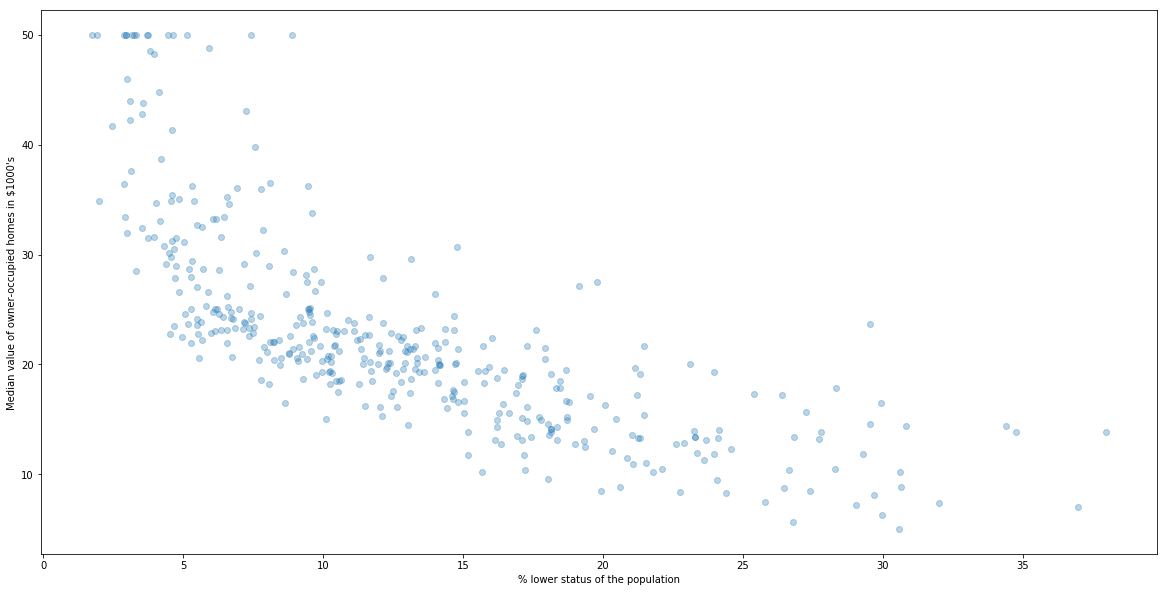

In [5]:
plt.scatter(X_train[:,0], y_train, alpha=0.3)
plt.xlabel("% lower status of the population")
plt.ylabel("Median value of owner-occupied homes in $1000's")

In [6]:
from sklearn.linear_model import LinearRegression

skl_model = LinearRegression()
skl_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

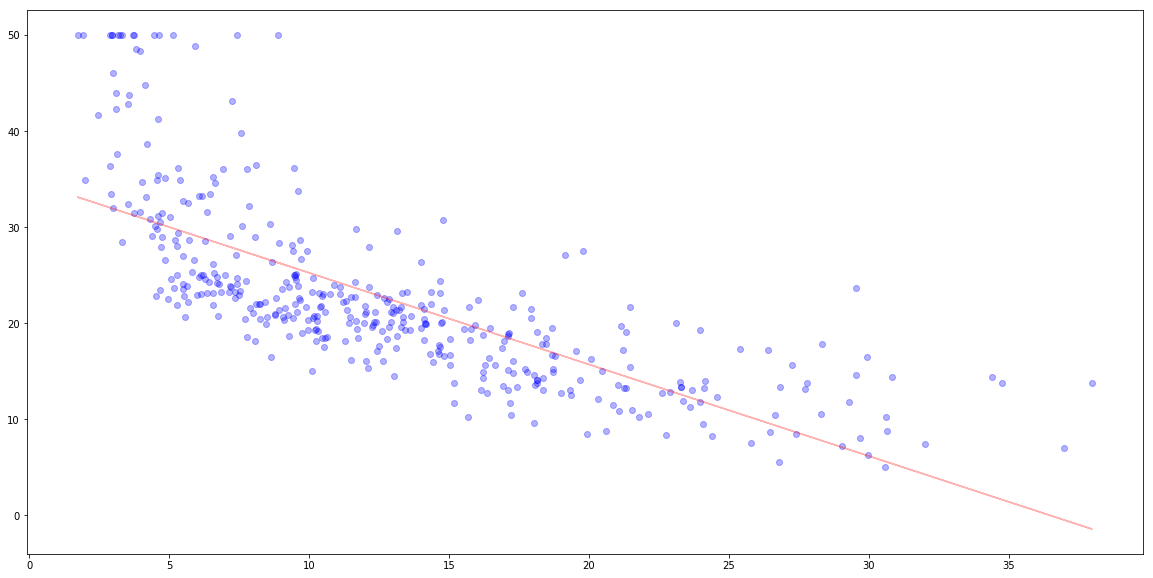

In [7]:
y_train_hat = skl_model.predict(X_train)
y_test_hat = skl_model.predict(X_test)

# Ploting real data y (blue)
plt.scatter(X_train[:,0], y_train, alpha=0.3, c="blue")
# versus predicted y_hat (red)
plt.plot(X_train[:,0], y_train_hat, alpha=0.3, c="red")
plt.show()

Los parametros entrenados son los siguentes:

In [8]:
skl_model.coef_, skl_model.intercept_

(array([-0.95352517]), 34.777848293674815)

Y su RMSE:

In [9]:
from sklearn.metrics import mean_squared_error
np.sqrt(np.sqrt(mean_squared_error(y_test, y_test_hat)))

2.417186764754931

### Pytorch model

Ahora hacemos el modelo usando `pytorch`. Primero tenemos que traducir objetos de `numpy` a `pytorch`.

In [10]:
def torch_X_y(X_train, X_test, y_train, y_test):
    X_train_torch = torch.from_numpy(X_train).float()
    X_test_torch = torch.from_numpy(X_test).float()
    y_train_torch = torch.tensor(y_train).float()
    y_test_torch = torch.tensor(y_test).float()
    return X_train_torch, X_test_torch, y_train_torch, y_test_torch
    
X_train_torch, X_test_torch, y_train_torch, y_test_torch = torch_X_y(X_train, X_test, y_train, y_test)

Definimos el modelo:

In [11]:
model = nn.Linear(in_features=1, out_features=1, bias=True)

En el principio sus cooficentes son aleratorios:

In [12]:
model.weight, model.bias

(Parameter containing:
 tensor([[0.1735]], requires_grad=True), Parameter containing:
 tensor([0.6708], requires_grad=True))

Ahora definimos la funcion objetivo y el optimizer `Adam` con learning rate `0.1`.

In [13]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

### Entrenar el modelo


Pasos:

1. Generar la salida (también llamado propagación de entrada hacia adelante, o en inglés forward pass)
2. Calcular función de pérdida (loss function)
3. Propagación de errores hacia atrás (backpropagation of errors)
4. Cambiar los pesos (update weights)

En el caso de `pytorch` hay un paso adicional
0. Anular los gradientes.

#### 0. Anular los gradientes.

In [14]:
optimizer.zero_grad()

#### 1. Generar la salida

In [15]:
y_train_hat = model(X_train_torch)

#### 2. Calcular función de pérdida

Aqui hay que tener un poco de cuidado. La salida tiene distincta forma que el output `y_train_torch`

In [16]:
y_train_hat[:5]

tensor([[1.9099],
        [3.6471],
        [3.2167],
        [3.0970],
        [2.6995]], grad_fn=<SliceBackward>)

In [17]:
y_train_torch[:5]

tensor([23.2000, 19.0000, 17.5000, 26.4000, 20.2000])

Por lo tanto tenemos que `unsueeze` el output:

In [18]:
y_train_torch.unsqueeze(1)[:5]

tensor([[23.2000],
        [19.0000],
        [17.5000],
        [26.4000],
        [20.2000]])

In [19]:
loss = loss_function(y_train_hat, y_train_torch.unsqueeze(1))

#### 3. Propagación de errores hacia atrás (backpropagation of errors)

In [20]:
loss.backward()

In [21]:
model.weight, model.bias

(Parameter containing:
 tensor([[0.1735]], requires_grad=True), Parameter containing:
 tensor([0.6708], requires_grad=True))

#### 4. Cambiar los pesos (update weights)

In [22]:
optimizer.step()

Weights despues de un paso

In [23]:
model.weight, model.bias

(Parameter containing:
 tensor([[0.2735]], requires_grad=True), Parameter containing:
 tensor([0.7708], requires_grad=True))

Son todavia muy lejos de los que hemos obtenido con `sklearn`. Pero lo que tenemos que hacer es poner estos pasos en un bucle.

In [24]:
model = nn.Linear(in_features=1, out_features=1, bias=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

n_epoch = 10000

for i in range(n_epoch):
    # 0. Anular los gradientes.
    optimizer.zero_grad()

    # 1. Generar la salida
    y_train_hat = model(X_train_torch) 
    # 2. Calcular función de pérdida
    loss = loss_function(y_train_hat, y_train_torch.unsqueeze(1))
    # 3. Backward propagation
    loss.backward()
    # 4. Cambiar los pesos
    optimizer.step()

Parametros despues de entrenamianto:

In [25]:
model.weight, model.bias

(Parameter containing:
 tensor([[-0.9535]], requires_grad=True), Parameter containing:
 tensor([34.7778], requires_grad=True))

Entonces son iguales como las que hemos obtenido con `sklearn`.

## Red neuronal y entrenamiento con batches.

Preparación de servir los batches.

In [97]:
X = boston.data
y = boston.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.2)
X_train_torch, X_test_torch, y_train_torch, y_test_torch = torch_X_y(X_train, X_test, y_train, y_test)

In [98]:
from torch.utils.data import Dataset, DataLoader

class BostonDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.data = torch.from_numpy(X).float()
        self.target = torch.from_numpy(y).float()
        self.transform = transform
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
    
train_dataset = BostonDataset(X_train, y_train)

In [99]:
n_epoch = 5000
batch_size=32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

in_features = X_train.shape[1]
test_size = X_test.shape[0]

model = nn.Linear(in_features=in_features, out_features=1, bias=True)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses_train = []
losses_test = []

for epoch in range(n_epoch):    
    train_iter = iter(train_loader)
    for X_batch, y_batch in train_iter:
        optimizer.zero_grad()
        y_batch_hat = model(X_batch)
        loss = criterion(y_batch_hat, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
    # claculte loss every epoch
    y_train_hat = model(X_train_torch[:test_size, :])
    loss_train = criterion(y_train_hat, y_train_torch[:test_size].unsqueeze(1)).detach().numpy()
    losses_train.append(loss_train)
    
    y_test_hat = model(X_test_torch)
    loss_test = criterion(y_test_hat, y_test_torch.unsqueeze(1)).detach().numpy()
    losses_test.append(loss_test)
    if (epoch + 1) % 100 == 0:
        # print every 100 epochs
        print(f"Epoch: {epoch}, loss train: {loss_train}, loss test: {loss_test}")

Epoch: 99, loss train: 53.50641632080078, loss test: 58.860321044921875
Epoch: 199, loss train: 44.017398834228516, loss test: 50.00879669189453
Epoch: 299, loss train: 38.716068267822266, loss test: 45.86624526977539
Epoch: 399, loss train: 35.235084533691406, loss test: 44.17742919921875
Epoch: 499, loss train: 31.310733795166016, loss test: 39.723480224609375
Epoch: 599, loss train: 29.150348663330078, loss test: 39.208126068115234
Epoch: 699, loss train: 27.109750747680664, loss test: 37.53201675415039
Epoch: 799, loss train: 25.64288330078125, loss test: 36.56253433227539
Epoch: 899, loss train: 24.092700958251953, loss test: 34.321693420410156
Epoch: 999, loss train: 23.56258201599121, loss test: 34.789817810058594
Epoch: 1099, loss train: 23.325366973876953, loss test: 35.27109146118164
Epoch: 1199, loss train: 22.042980194091797, loss test: 33.403053283691406
Epoch: 1299, loss train: 21.385419845581055, loss test: 31.59642791748047
Epoch: 1399, loss train: 20.911088943481445, l

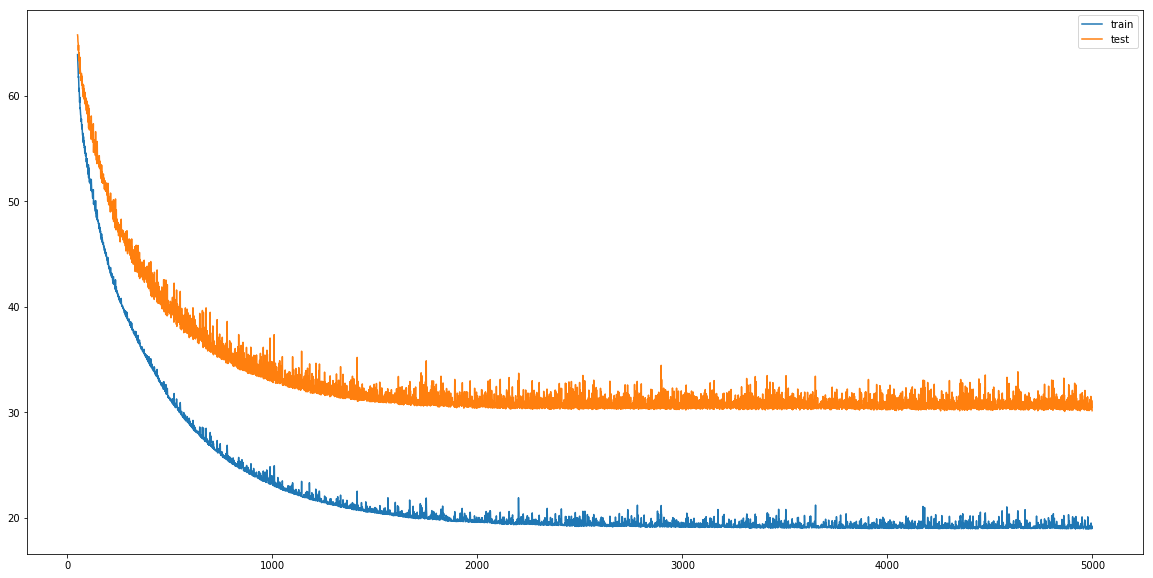

In [100]:
plt.plot(range(50, n_epoch), losses_train[50:], label="train")
plt.plot(range(50, n_epoch), losses_test[50:], label="test")
plt.legend()
plt.show()

In [101]:
model.weight, model.bias

(Parameter containing:
 tensor([[-0.0588,  0.0515,  0.0114,  2.7970,  0.5055,  5.4534, -0.0057, -1.0146,
           0.1889, -0.0127, -0.5205,  0.0150, -0.4746]], requires_grad=True),
 Parameter containing:
 tensor([4.8087], requires_grad=True))

### Multilayer NN

In [113]:
from collections import OrderedDict
model = nn.Sequential(
    OrderedDict([
        ('fc0', nn.Linear(in_features=in_features, out_features=64, bias=True)),
        ('relu1', nn.ReLU()),
        ('fc1', nn.Linear(in_features=64, out_features=32, bias=True)),
        ('relu2', nn.ReLU()),
        ('fc2', nn.Linear(in_features=32, out_features=16, bias=True)),
        ('relu3', nn.ReLU()),
        ('fc3', nn.Linear(in_features=16, out_features=1, bias=True)),
    ]))
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Sequential(
  (fc0): Linear(in_features=13, out_features=64, bias=True)
  (relu1): ReLU()
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [114]:
losses_train = []
losses_test = []

for epoch in range(n_epoch):    
    train_iter = iter(train_loader)
    for X_batch, y_batch in train_iter:
        optimizer.zero_grad()
        y_batch_hat = model(X_batch)
        loss = criterion(y_batch_hat, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
    # claculte loss every epoch
    y_train_hat = model(X_train_torch[:test_size, :])
    loss_train = criterion(y_train_hat, y_train_torch[:test_size].unsqueeze(1)).detach().numpy()
    losses_train.append(loss_train)
    
    y_test_hat = model(X_test_torch)
    loss_test = criterion(y_test_hat, y_test_torch.unsqueeze(1)).detach().numpy()
    losses_test.append(loss_test)
    if (epoch + 1) % 100 == 0:
        # print every 100 epochs
        print(f"Epoch: {epoch}, loss train: {loss_train}, loss test: {loss_test}")

Epoch: 99, loss train: 37.049381256103516, loss test: 48.32489013671875
Epoch: 199, loss train: 27.745922088623047, loss test: 37.6677360534668
Epoch: 299, loss train: 21.900806427001953, loss test: 30.911590576171875
Epoch: 399, loss train: 19.390640258789062, loss test: 27.640474319458008
Epoch: 499, loss train: 16.909814834594727, loss test: 26.030261993408203
Epoch: 599, loss train: 14.804851531982422, loss test: 23.54559898376465
Epoch: 699, loss train: 13.427774429321289, loss test: 22.050661087036133
Epoch: 799, loss train: 12.453449249267578, loss test: 20.86193084716797
Epoch: 899, loss train: 12.572208404541016, loss test: 22.732494354248047
Epoch: 999, loss train: 11.525277137756348, loss test: 21.182781219482422
Epoch: 1099, loss train: 11.319465637207031, loss test: 19.949678421020508
Epoch: 1199, loss train: 11.305519104003906, loss test: 21.63054847717285
Epoch: 1299, loss train: 10.26292896270752, loss test: 19.780139923095703
Epoch: 1399, loss train: 10.481978416442871

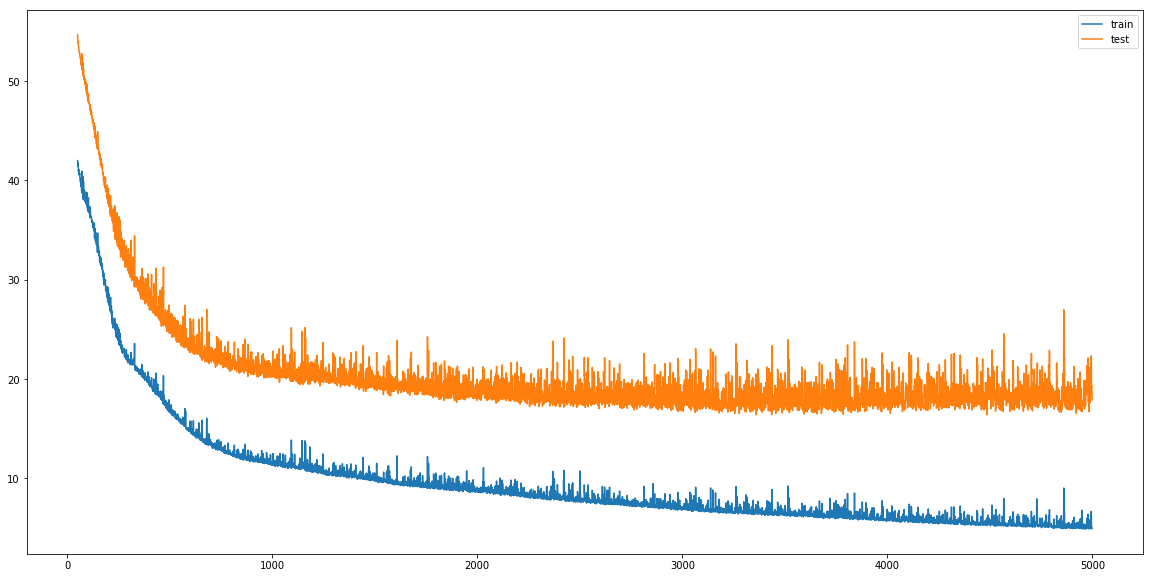

In [115]:
plt.plot(range(50, n_epoch), losses_train[50:], label="train")
plt.plot(range(50, n_epoch), losses_test[50:], label="test")
plt.legend()
plt.show()

## Logistic regression: the simples NN

In [76]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data[:, [12]].astype(np.float32)
y = (data.target == 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.2)

In [77]:
def torch_X_y_binary_classification(X_train, X_test, y_train, y_test):
    X_train_torch = torch.from_numpy(X_train).float()
    X_test_torch = torch.from_numpy(X_test).float()
    y_train_torch = torch.tensor(y_train)
    y_test_torch = torch.tensor(y_test)
    return X_train_torch, X_test_torch, y_train_torch, y_test_torch
 
X_train_torch, X_test_torch, y_train_torch, y_test_torch = \
    torch_X_y_binary_classification(X_train, X_test, y_train, y_test)

In [78]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.tensor(y_train.astype(float)).float()

In [79]:
in_features = X_train.shape[1]
model = nn.Sequential(OrderedDict([
                      ('fc', nn.Linear(in_features=in_features, out_features=1, bias=True)),
                      ('sigmoid', nn.Sigmoid())]))

In [80]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [93]:
n_epoch = 10000

for i in range(n_epoch):
    # 0. Anular los gradientes.
    optimizer.zero_grad()
    # 1. Generar la salida
    y_train_hat = model(X_train_torch) 
    # 2. Calcular función de pérdida
    loss = loss_function(y_train_hat, y_train_torch.unsqueeze(1))
    # 3. Backward propagation
    loss.backward()
    # 4. Cambiar los pesos
    optimizer.step()

In [94]:
y_test_score = model(X_test_torch).squeeze().detach().numpy()

In [95]:
y_test_hat = (y_test_score >= 0.5)

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy score :", accuracy_score(y_test, y_test_hat))
print("Precision :", precision_score(y_test, y_test_hat))
print("Recall :", recall_score(y_test, y_test_hat))
print("F1-score :", f1_score(y_test, y_test_hat))

Accuracy score : 0.8157894736842105
Precision : 0.8205128205128205
Recall : 0.6956521739130435
F1-score : 0.7529411764705882
